In [54]:
pip install --upgrade xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\ProgramData\anaconda3\python.exe -m pip install --upgrade pip


In [1]:
import pickle

import warnings

import numpy as np

import pandas as pd

import xgboost as xgb

import sklearn
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings("ignore")

## 3. Read Datasets

In [5]:
file_path = r"C:\Users\khans\OneDrive\Desktop\AWS Project\data\train.csv"
train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,21/03/2019,Bangalore,New Delhi,BLR → BOM → DEL,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,27/03/2019,Delhi,Cochi,DEL → BOM → COK,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,09/03/2019,Bangalore,New Delhi,BLR → DEL,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,12/06/2019,Kolkata,Banglore,CCU → BOM → BLR,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,12/03/2019,Bangalore,New Delhi,BLR → BOM → DEL,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,21/03/2019,Delhi,Cochi,DEL → BDQ → BOM → COK,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,1/05/2019,Kolkata,Banglore,CCU → BOM → BLR,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,1/06/2019,Delhi,Cochi,DEL → BOM → COK,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,24/06/2019,Delhi,Cochi,DEL → BLR → COK,07:55:00,13:25:00,330,1.0,No Info,6152


In [6]:
file_path = r"C:\Users\khans\OneDrive\Desktop\AWS Project\data\val.csv"
val = pd.read_csv(file_path)
val

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,24/06/2019,Delhi,Cochi,DEL → BOM → COK,20:25:00,01:30:00,305,1.0,No Info,5054
1,Multiple Carriers,12/06/2019,Delhi,Cochi,DEL → HYD → COK,09:45:00,22:30:00,765,1.0,No Info,9646
2,Jet Airways,12/03/2019,Bangalore,New Delhi,BLR → BOM → DEL,22:55:00,15:15:00,980,1.0,In-flight meal not included,11087
3,Multiple Carriers,6/06/2019,Delhi,Cochi,DEL → BOM → COK,13:00:00,21:00:00,480,1.0,No Info,13587
4,Jet Airways,18/05/2019,Delhi,Cochi,DEL → AMD → BOM → COK,23:05:00,04:25:00,1760,2.0,No Info,16704
...,...,...,...,...,...,...,...,...,...,...,...
1669,Spicejet,1/05/2019,Chennai,Kolkata,MAA → CCU,09:45:00,12:00:00,135,0.0,No Info,3597
1670,Indigo,1/05/2019,Kolkata,Banglore,CCU → MAA → BLR,08:10:00,13:00:00,290,1.0,No Info,5069
1671,Jet Airways,27/05/2019,Delhi,Cochi,DEL → BHO → BOM → COK,05:30:00,12:35:00,425,2.0,In-flight meal not included,15544
1672,Jet Airways,12/06/2019,Mumbai,Hyderabad,BOM → HYD,19:35:00,21:05:00,90,0.0,In-flight meal not included,3210


In [7]:
file_path = r"C:\Users\khans\OneDrive\Desktop\AWS Project\data\test.csv"
test = pd.read_csv(file_path)
test

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,06/03/2019,Bangalore,New Delhi,BLR → BOM → DEL,08:00:00,08:15:00,1455,1.0,No Info,17996
1,Spicejet,6/06/2019,Kolkata,Banglore,CCU → BLR,22:20:00,00:40:00,140,0.0,No Info,3873
2,Indigo,18/03/2019,Kolkata,Banglore,CCU → BLR,05:30:00,08:20:00,170,0.0,No Info,4462
3,Indigo,27/06/2019,Chennai,Kolkata,MAA → CCU,19:35:00,21:55:00,140,0.0,No Info,3597
4,Indigo,6/05/2019,Kolkata,Banglore,CCU → BLR,15:15:00,17:45:00,150,0.0,No Info,4804
...,...,...,...,...,...,...,...,...,...,...,...
2088,Jet Airways,27/05/2019,Delhi,Cochi,DEL → BOM → COK,19:15:00,12:35:00,1040,1.0,In-flight meal not included,12898
2089,Multiple Carriers,27/06/2019,Delhi,Cochi,DEL → BOM → COK,11:25:00,19:15:00,470,1.0,No Info,7155
2090,Jet Airways,3/06/2019,Delhi,Cochi,DEL → BOM → COK,02:15:00,04:25:00,1570,1.0,In-flight meal not included,11627
2091,Multiple Carriers,6/06/2019,Delhi,Cochi,DEL → BOM → COK,15:15:00,01:30:00,615,1.0,No Info,6795


## 4. Preprocessing Operations

In [8]:
# airline
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

#doj
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

# source & destination
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

# dep_time & arrival_time
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                 X_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

# duration
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma


    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }

        return self


    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)

    

def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short),
                                    X.duration.between(short, med, inclusive="left")],
                                    ["short", "medium"],
                                    default="long"))
        .drop(columns="duration")
    )

def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

# total_stops
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

# additional_info
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

info_union = FeatureUnion(transformer_list=[
("part1", info_pipe1),
("part2", FunctionTransformer(func=have_info))
])

info_transformer = Pipeline(steps=[
("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
("union", info_union)
])

# column transformer
column_transformer = ColumnTransformer(transformers=[
("air", air_transformer, ["airline"]),
("doj", doj_transformer, ["date_of_journey"]),
("location", location_transformer, ["source", 'destination']),
("time", time_transformer, ["dep_time", "arrival_time"]),
("dur", duration_transformer, ["duration"]),
("stops", total_stops_transformer, ["total_stops"]),
("info", info_transformer, ["additional_info"])
], remainder="passthrough")

# feature selector
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
estimator=estimator,
scoring="r2",
threshold=0.1
) 

# preprocessor
preprocessor = Pipeline(steps=[
("ct", column_transformer),
("selector", selector)
])

In [9]:
preprocessor.fit(
    train.drop(columns="price"),
    train.price.copy()
)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001D2ECADA840>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [10]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'route',
       'dep_time', 'arrival_time', 'duration', 'total_stops',
       'additional_info', 'price'],
      dtype='object')

In [22]:
train.drop(["price", "route"], axis = "columns")

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,21/03/2019,Bangalore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included
1,Jet Airways,27/03/2019,Delhi,Cochi,17:30:00,04:25:00,655,1.0,In-flight meal not included
2,Goair,09/03/2019,Bangalore,New Delhi,11:40:00,14:35:00,175,0.0,No Info
3,Air India,12/06/2019,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info
4,Jet Airways,12/03/2019,Bangalore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included
...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,21/03/2019,Delhi,Cochi,10:45:00,18:50:00,1925,2.0,No Info
6691,Air India,1/05/2019,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info
6692,Jet Airways,1/06/2019,Delhi,Cochi,14:00:00,19:00:00,300,1.0,In-flight meal not included
6693,Air Asia,24/06/2019,Delhi,Cochi,07:55:00,13:25:00,330,1.0,No Info


In [11]:
preprocessor.transform(train.drop(columns="price"))
# type(preprocessor.transform(train.drop(columns="price")))

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,remainder__route
0,0.0,1.0,0.0,0.228487,-0.857930,-0.736484,-0.364262,2.0,0,-0.033916,1.0,0,BLR → BOM → DEL
1,0.0,1.0,0.0,0.246291,1.065418,1.061694,-0.364262,2.0,0,0.046422,1.0,0,DEL → BOM → COK
2,0.0,0.0,1.0,0.721068,-0.857930,-0.736484,2.373008,0.0,0,-0.917631,0.0,1,BLR → DEL
3,0.0,0.0,0.0,1.000000,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0,CCU → BOM → BLR
4,0.0,1.0,0.0,0.991098,-0.857930,-0.736484,-0.364262,2.0,0,-0.214676,1.0,0,BLR → BOM → DEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.228487,1.065418,1.061694,-0.364262,2.0,1,2.597145,2.0,0,DEL → BDQ → BOM → COK
6691,0.0,0.0,0.0,0.005935,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0,CCU → BOM → BLR
6692,0.0,1.0,0.0,0.008902,1.065418,1.061694,-0.364262,1.0,0,-0.666576,1.0,0,DEL → BOM → COK
6693,0.0,0.0,1.0,0.510386,1.065418,1.061694,-0.364262,1.0,0,-0.606322,1.0,0,DEL → BLR → COK


In [12]:
train

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,21/03/2019,Bangalore,New Delhi,BLR → BOM → DEL,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,27/03/2019,Delhi,Cochi,DEL → BOM → COK,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,09/03/2019,Bangalore,New Delhi,BLR → DEL,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,12/06/2019,Kolkata,Banglore,CCU → BOM → BLR,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,12/03/2019,Bangalore,New Delhi,BLR → BOM → DEL,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,21/03/2019,Delhi,Cochi,DEL → BDQ → BOM → COK,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,1/05/2019,Kolkata,Banglore,CCU → BOM → BLR,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,1/06/2019,Delhi,Cochi,DEL → BOM → COK,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,24/06/2019,Delhi,Cochi,DEL → BLR → COK,07:55:00,13:25:00,330,1.0,No Info,6152


In [15]:
file_name = "train_pre.csv"
train_pre = preprocessor.transform(train.drop(columns="price"))


In [16]:
train_pre.to_csv(file_name, index=False)

In [24]:
file_name = "val_pre.csv"
val_pre = preprocessor.transform(val.drop(columns="price"))
val_pre.to_csv(file_name, index=False)

In [27]:
file_name = "test_pre.csv"
test_pre = preprocessor.transform(test.drop(columns="price"))
test_pre.to_csv(file_name, index=False)

## 5. Model and Hyperparameter Tuning Set-up

In [29]:
X_train, y_train = pd.read_csv("train_pre.csv").drop(columns = "remainder__route"), train.price

In [30]:
X_train

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.228487,-0.857930,-0.736484,-0.364262,2.0,0,-0.033916,1.0,0
1,0.0,1.0,0.0,0.246291,1.065418,1.061694,-0.364262,2.0,0,0.046422,1.0,0
2,0.0,0.0,1.0,0.721068,-0.857930,-0.736484,2.373008,0.0,0,-0.917631,0.0,1
3,0.0,0.0,0.0,1.000000,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
4,0.0,1.0,0.0,0.991098,-0.857930,-0.736484,-0.364262,2.0,0,-0.214676,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.228487,1.065418,1.061694,-0.364262,2.0,1,2.597145,2.0,0
6691,0.0,0.0,0.0,0.005935,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
6692,0.0,1.0,0.0,0.008902,1.065418,1.061694,-0.364262,1.0,0,-0.666576,1.0,0
6693,0.0,0.0,1.0,0.510386,1.065418,1.061694,-0.364262,1.0,0,-0.606322,1.0,0


In [37]:
X_train.columns

Index(['air__airline_Indigo', 'air__airline_Jet Airways', 'air__airline_Other',
       'doj__date_of_journey_day_of_year', 'location__source',
       'location__destination', 'dur__duration_rbf_25', 'dur__duration_cat',
       'dur__duration_over_1000', 'dur__duration', 'stops__total_stops',
       'stops__is_direct_flight'],
      dtype='object')

In [25]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'route',
       'dep_time', 'arrival_time', 'duration', 'total_stops',
       'additional_info', 'price'],
      dtype='object')

In [28]:
X_train, y_train = train.drop(columns = ["route", "price"] ), train.price

In [29]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,21/03/2019,Bangalore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included
1,Jet Airways,27/03/2019,Delhi,Cochi,17:30:00,04:25:00,655,1.0,In-flight meal not included
2,Goair,09/03/2019,Bangalore,New Delhi,11:40:00,14:35:00,175,0.0,No Info
3,Air India,12/06/2019,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info
4,Jet Airways,12/03/2019,Bangalore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included
...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,21/03/2019,Delhi,Cochi,10:45:00,18:50:00,1925,2.0,No Info
6691,Air India,1/05/2019,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info
6692,Jet Airways,1/06/2019,Delhi,Cochi,14:00:00,19:00:00,300,1.0,In-flight meal not included
6693,Air Asia,24/06/2019,Delhi,Cochi,07:55:00,13:25:00,330,1.0,No Info


In [30]:
y_train

0        7832
1        6540
2        7305
3        8366
4       11087
        ...  
6690    11093
6691     8891
6692    10262
6693     6152
6694    14594
Name: price, Length: 6695, dtype: int64

In [31]:
X_val, y_val = val.drop(columns = ["route", "price"] ), val.price

In [32]:
X_val

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Indigo,24/06/2019,Delhi,Cochi,20:25:00,01:30:00,305,1.0,No Info
1,Multiple Carriers,12/06/2019,Delhi,Cochi,09:45:00,22:30:00,765,1.0,No Info
2,Jet Airways,12/03/2019,Bangalore,New Delhi,22:55:00,15:15:00,980,1.0,In-flight meal not included
3,Multiple Carriers,6/06/2019,Delhi,Cochi,13:00:00,21:00:00,480,1.0,No Info
4,Jet Airways,18/05/2019,Delhi,Cochi,23:05:00,04:25:00,1760,2.0,No Info
...,...,...,...,...,...,...,...,...,...
1669,Spicejet,1/05/2019,Chennai,Kolkata,09:45:00,12:00:00,135,0.0,No Info
1670,Indigo,1/05/2019,Kolkata,Banglore,08:10:00,13:00:00,290,1.0,No Info
1671,Jet Airways,27/05/2019,Delhi,Cochi,05:30:00,12:35:00,425,2.0,In-flight meal not included
1672,Jet Airways,12/06/2019,Mumbai,Hyderabad,19:35:00,21:05:00,90,0.0,In-flight meal not included


In [33]:
y_val

0        5054
1        9646
2       11087
3       13587
4       16704
        ...  
1669     3597
1670     5069
1671    15544
1672     3210
1673    14714
Name: price, Length: 1674, dtype: int64

In [34]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Assuming train.csv, val.csv, and test.csv are loaded into pandas DataFrames


def objective(trial):
    # Step 1: Define the hyperparameter search space for XGBoost
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
    }

    # Step 2: Create the full pipeline with the preprocessor and the XGBoost model
    model_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", xgb.XGBRegressor(**params))
    ])

    # Step 3: Train the model
    model_pipeline.fit(X_train, y_train)

    # Step 4: Evaluate the model on the validation set
    y_pred = model_pipeline.predict(X_val)
    r2 = r2_score(y_val, y_pred)

    # Optuna's goal is to maximize R-squared, so we return the score directly
    return r2

In [35]:
# Create an Optuna study. We want to maximize the R-squared score.
study = optuna.create_study(direction="maximize")

# Run the optimization process for a certain number of trials
study.optimize(objective, n_trials=50) # You can adjust n_trials

# Print the best hyperparameters and score found
print("Best hyperparameters: ", study.best_params)
print("Best R-squared score: ", study.best_value)

# You can also get the best trial object
best_trial = study.best_trial

[I 2025-09-10 10:49:46,109] A new study created in memory with name: no-name-9c96ed1a-6a72-4715-b4ed-8664b3b66385
[I 2025-09-10 10:49:47,944] Trial 0 finished with value: 0.6926711797714233 and parameters: {'n_estimators': 500, 'learning_rate': 0.2100724966979112, 'max_depth': 9, 'subsample': 0.8543186083226714, 'colsample_bytree': 0.685359330975011, 'gamma': 6.833512507900935e-08, 'min_child_weight': 8}. Best is trial 0 with value: 0.6926711797714233.
[I 2025-09-10 10:49:50,013] Trial 1 finished with value: 0.771819531917572 and parameters: {'n_estimators': 600, 'learning_rate': 0.011418875921647583, 'max_depth': 9, 'subsample': 0.8612562801319824, 'colsample_bytree': 0.6258863017212155, 'gamma': 1.9316558398482336e-05, 'min_child_weight': 8}. Best is trial 1 with value: 0.771819531917572.
[I 2025-09-10 10:49:51,936] Trial 2 finished with value: 0.754858136177063 and parameters: {'n_estimators': 200, 'learning_rate': 0.09535505678690125, 'max_depth': 9, 'subsample': 0.8322889382584946

Best hyperparameters:  {'n_estimators': 600, 'learning_rate': 0.014430859043285334, 'max_depth': 9, 'subsample': 0.8522876639487925, 'colsample_bytree': 0.600150231157643, 'gamma': 0.0005832192191303875, 'min_child_weight': 7}
Best R-squared score:  0.7752800583839417


In [51]:
pip list --outdated

Package                       Version      Latest      Type
----------------------------- ------------ ----------- -----
absl-py                       2.1.0        2.3.1       wheel
aiobotocore                   2.7.0        2.24.2      wheel
aiohttp                       3.9.0        3.12.15     wheel
aioitertools                  0.7.1        0.12.0      wheel
aiosignal                     1.2.0        1.4.0       wheel
alabaster                     0.7.12       1.0.0       wheel
alembic                       1.14.1       1.16.5      wheel
anaconda-client               1.12.1       1.13.0      wheel
anaconda-cloud-auth           0.1.4        0.7.2       wheel
anyio                         3.5.0        4.10.0      wheel
archspec                      0.2.1        0.2.5       wheel
argon2-cffi                   21.3.0       25.1.0      wheel
argon2-cffi-bindings          21.2.0       25.1.0      wheel
arrow                         1.2.3        1.3.0       wheel
astroid                  


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\ProgramData\anaconda3\python.exe -m pip install --upgrade pip


In [52]:
pip install --upgrade xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   - -------------------------------------- 2.1/56.8 MB 11.7 MB/s eta 0:00:05
   ---- ----------------------------------- 5.8/56.8 MB 16.0 MB/s eta 0:00:04
   ------- -------------------------------- 10.7/56.8 MB 18.6 MB/s eta 0:00:03
   ----------- ---------------------------- 17.0/56.8 MB 21.9 MB/s eta 0:00:02
   --------------- ------------------------ 21.8/56.8 MB 22.2 MB/s eta 0:00:02
   -------------------- ------------------- 29.1/56.8 MB 24.3 MB/s eta 0:00:02
   -------------------------- ------------- 37.5/56.8 MB 26.8 MB/s eta 0:00:01
   --------------------------------- ------ 47.7/56.8 MB 29.8 MB/s eta 0:00:01
   ---------------------------------------  56.6/56.8 MB 31.4 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 29.9 MB/s eta 0:

  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\ProgramData\anaconda3\python.exe -m pip install --upgrade pip


In [36]:
# Print the best hyperparameters and score found
print("Best hyperparameters: ", study.best_params)
print("Best R-squared score: ", study.best_value)

Best hyperparameters:  {'n_estimators': 600, 'learning_rate': 0.014430859043285334, 'max_depth': 9, 'subsample': 0.8522876639487925, 'colsample_bytree': 0.600150231157643, 'gamma': 0.0005832192191303875, 'min_child_weight': 7}
Best R-squared score:  0.7752800583839417


In [38]:
# Combine train and val data for final training
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = pd.concat([y_train, y_val], ignore_index=True)

In [39]:
X_full_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,21/03/2019,Bangalore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included
1,Jet Airways,27/03/2019,Delhi,Cochi,17:30:00,04:25:00,655,1.0,In-flight meal not included
2,Goair,09/03/2019,Bangalore,New Delhi,11:40:00,14:35:00,175,0.0,No Info
3,Air India,12/06/2019,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info
4,Jet Airways,12/03/2019,Bangalore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included
...,...,...,...,...,...,...,...,...,...
8364,Spicejet,1/05/2019,Chennai,Kolkata,09:45:00,12:00:00,135,0.0,No Info
8365,Indigo,1/05/2019,Kolkata,Banglore,08:10:00,13:00:00,290,1.0,No Info
8366,Jet Airways,27/05/2019,Delhi,Cochi,05:30:00,12:35:00,425,2.0,In-flight meal not included
8367,Jet Airways,12/06/2019,Mumbai,Hyderabad,19:35:00,21:05:00,90,0.0,In-flight meal not included


In [40]:
y_full_train

0        7832
1        6540
2        7305
3        8366
4       11087
        ...  
8364     3597
8365     5069
8366    15544
8367     3210
8368    14714
Name: price, Length: 8369, dtype: int64

In [41]:
X_test, y_test = test.drop(columns = ["route", "price"] ), test.price

In [42]:
X_test

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,06/03/2019,Bangalore,New Delhi,08:00:00,08:15:00,1455,1.0,No Info
1,Spicejet,6/06/2019,Kolkata,Banglore,22:20:00,00:40:00,140,0.0,No Info
2,Indigo,18/03/2019,Kolkata,Banglore,05:30:00,08:20:00,170,0.0,No Info
3,Indigo,27/06/2019,Chennai,Kolkata,19:35:00,21:55:00,140,0.0,No Info
4,Indigo,6/05/2019,Kolkata,Banglore,15:15:00,17:45:00,150,0.0,No Info
...,...,...,...,...,...,...,...,...,...
2088,Jet Airways,27/05/2019,Delhi,Cochi,19:15:00,12:35:00,1040,1.0,In-flight meal not included
2089,Multiple Carriers,27/06/2019,Delhi,Cochi,11:25:00,19:15:00,470,1.0,No Info
2090,Jet Airways,3/06/2019,Delhi,Cochi,02:15:00,04:25:00,1570,1.0,In-flight meal not included
2091,Multiple Carriers,6/06/2019,Delhi,Cochi,15:15:00,01:30:00,615,1.0,No Info


In [43]:
y_test

0       17996
1        3873
2        4462
3        3597
4        4804
        ...  
2088    12898
2089     7155
2090    11627
2091     6795
2092    13377
Name: price, Length: 2093, dtype: int64

In [44]:
# Combine train and val data for final training
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = pd.concat([y_train, y_val], ignore_index=True)

# Build the final model pipeline with the best hyperparameters
final_model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBRegressor(**study.best_params))
])

# Train the final model on the full training data
final_model_pipeline.fit(X_full_train, y_full_train)

# Evaluate on the test set
final_pred = final_model_pipeline.predict(X_test)
final_r2 = r2_score(y_test, final_pred)

print(f"Final R-squared on the test set: {final_r2}")

Final R-squared on the test set: 0.768398642539978


In [49]:
type(y_test),type(final_pred)

(pandas.core.series.Series, numpy.ndarray)

In [56]:
pd.Series(final_pred), type(pd.Series(final_pred))

(0       16153.339844
 1        4019.541016
 2        4223.307617
 3        3954.341309
 4        4809.505859
             ...     
 2088    13151.556641
 2089     9693.168945
 2090    11089.279297
 2091    10649.099609
 2092    11261.156250
 Length: 2093, dtype: float32,
 pandas.core.series.Series)

In [61]:
result_df = pd.concat([y_test,pd.Series(final_pred)], axis = 1 )
result_df.columns = ["Actual price", "Predicted Price"]

In [62]:
result_df

,Actual price,Predicted Price
0,17996,16153.339844
1,3873,4019.541016
2,4462,4223.307617
3,3597,3954.341309
4,4804,4809.505859
...,...,...
2088,12898,13151.556641
2089,7155,9693.168945
2090,11627,11089.279297
2091,6795,10649.099609


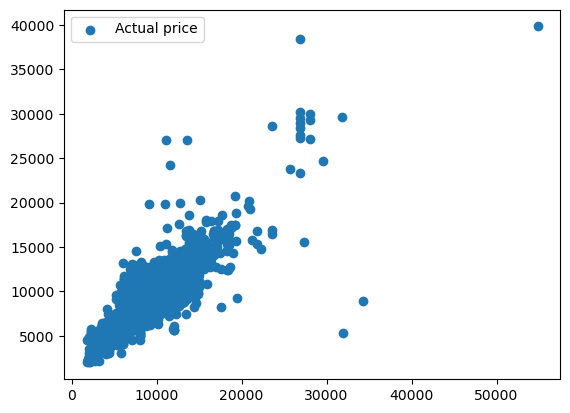

In [69]:
import matplotlib.pyplot as plt
plt.scatter(result_df["Actual price"],result_df[ "Predicted Price"])
plt.legend(["Actual price", "Predicted Price"])

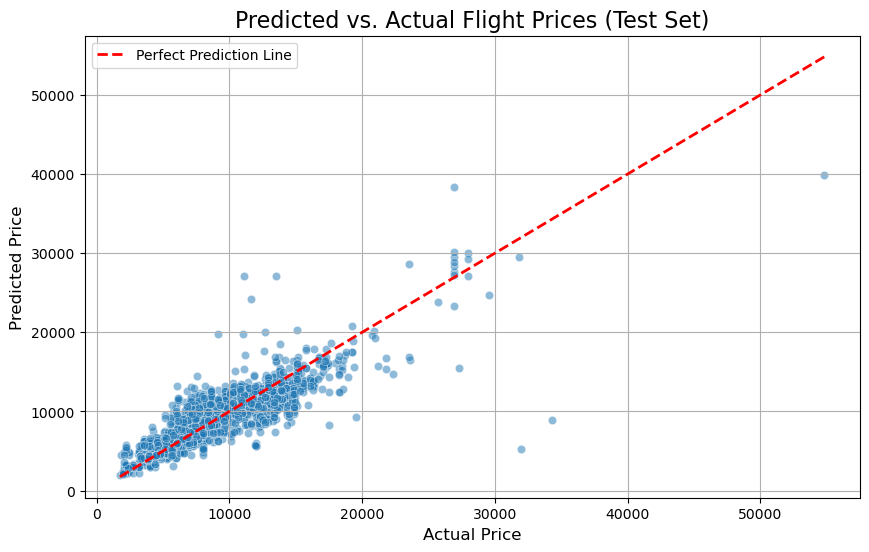

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=final_pred, alpha=0.5)

# Add a y=x line to represent perfect predictions
min_val = min(y_test.min(), final_pred.min())
max_val = max(y_test.max(), final_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction Line')

plt.title('Predicted vs. Actual Flight Prices (Test Set)', fontsize=16)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

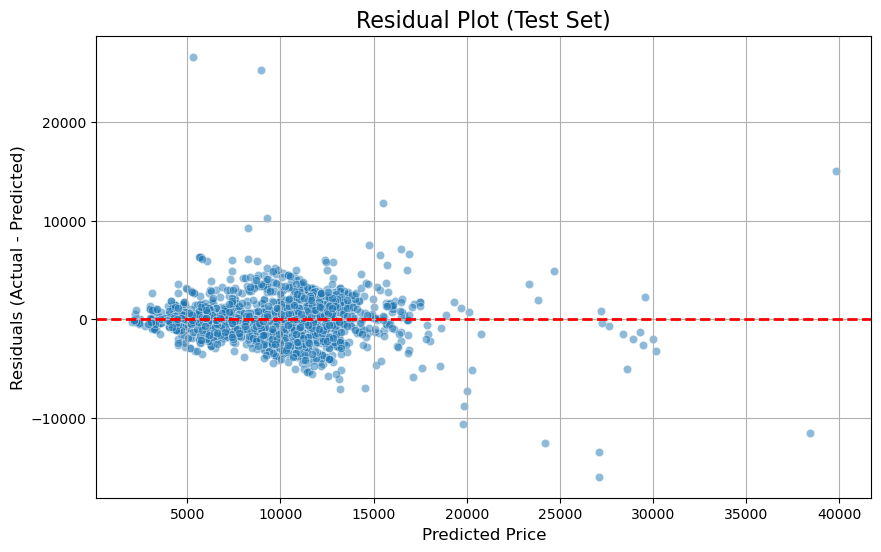

In [73]:
# Calculate residuals
residuals = y_test - final_pred

# Create a residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_pred, y=residuals, alpha=0.5)

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', lw=2)

plt.title('Residual Plot (Test Set)', fontsize=16)
plt.xlabel('Predicted Price', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True)
plt.show()

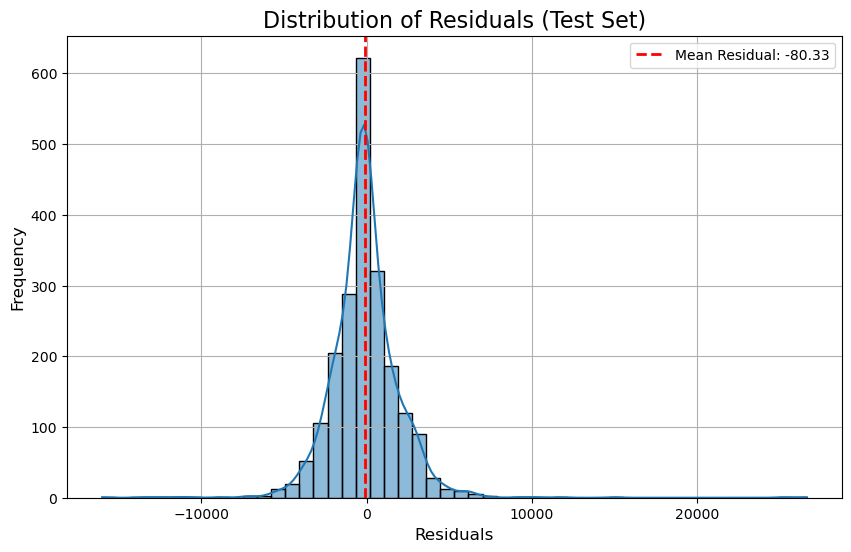

In [74]:
# Create a histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)

# Add a vertical line at the mean of the residuals
plt.axvline(x=residuals.mean(), color='red', linestyle='--', lw=2, label=f'Mean Residual: {residuals.mean():.2f}')

plt.title('Distribution of Residuals (Test Set)', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [75]:
import joblib

# Save the entire trained pipeline
joblib.dump(final_model_pipeline, 'flight_price_model.pkl')

['flight_price_model.pkl']